## Sentiment Analysis with Bidirectional Encoder Representations from Transformers(BERT)

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.
Dataset [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

## Setup


In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # Useing the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Explore the directory structure of dataset

In [3]:
import os
import shutil

# parent directory is "Deep Learning Tutorials"
parent_dir = os.path.join(os.getcwd(), "..")  # Move one level up from the current directory
bert_dir = os.path.join(parent_dir, "bert")

dataset_dir = os.path.join(bert_dir, "imdb")  # "imdb" is the folder containing the dataset
train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

### Set all the Constants


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

### Train Test Validation Set

Here, using the `text_dataset_from_directory` api to create tensor dataset `tf.data.Dataset`.

The dataset already divided into train and test, but there has no validation set. So, creating a validation set using an 80/20 split of the training data by using the `validation_split` argument.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [3]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'imdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [4]:
class_names = raw_train_ds.class_names
class_names

['neg', 'pos']

In [5]:
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'imdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'imdb/test',
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)


2024-03-27 01:01:45.476580: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

We can choose any BERT model, load from TensorFlow Hub and fine-tune. There are multiple BERT models available.


In [7]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## The preprocessing model Explaination

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before input to BERT. TensorFlow Hub provides a matching preprocessing model for each BERT models, which implements this transformation.

Note: Need to load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [9]:
text_test = ['this is really a very good series!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2428 1037 2200 2204 2186  999  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Above we can see, 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

NB:
- The input is truncated to 128 tokens. The number of tokens can be customized.
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in our model directly.

### Using the BERT model

Before putting BERT into our model, let's take a look at its outputs. It will load from TF Hub and returned values.

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
#print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
#print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Sequence Outputs Shape:(1, 128, 768)


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. You can think, Embedding for an entire sentence in form of numbers. The shape is `[batch_size, H]`.

- `sequence_output` represents each input token in the context. You can think of this as a contextual embedding for every token in the sentence. The shape is `[batch_size, seq_length, H]`.

- `encoder_outputs` is the encoder output of all 12 encoder layers and the last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define model(building functional model)

Creating a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Here specifically, we don't need to worry about it because the preprocessing model will take care of that.

Functional model offers more flexibility because we don't need to attach layers in sequential order. 

`input1 = Input(shape=(X_train.shape[1],))`

`hidden1 = Dense(5, activation='sigmoid')(input1)`

`hidden2 = Dense(4, activation='sigmoid')(hidden1)`

`output = Dense(10, activation='softmax')(hidden2)`

The final step of using functional style is to initialize the entire architecture. It can be achieved using Model() function along with its parameters which defines the input and output layer.

`model_func = Model(inputs=input1, outputs=output)`

More details: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057


### Building Function Classifier 

In [12]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [13]:
clf_model = build_classifier_model()
bert_raw_result = clf_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.8068977]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

## Model training

Now, we have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), 
using `losses.BinaryCrossentropy` loss function.


In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, using the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [15]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [16]:
clf_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [17]:
history = clf_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs)

Epoch 1/3
625/625 [==============================] - 32900s 53s/step - loss: 0.3842 - binary_accuracy: 0.8140 - val_loss: 0.3244 - val_binary_accuracy: 0.8812
Epoch 2/3
625/625 [==============================] - 19816s 32s/step - loss: 0.2073 - binary_accuracy: 0.9182 - val_loss: 0.3541 - val_binary_accuracy: 0.8912
Epoch 3/3
625/625 [==============================] - 24419s 39s/step - loss: 0.1124 - binary_accuracy: 0.9630 - val_loss: 0.4256 - val_binary_accuracy: 0.8862


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [19]:
loss, accuracy = clf_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 11103s 14s/step - loss: 0.4104 - binary_accuracy: 0.8891
Loss: 0.4103848934173584
Accuracy: 0.8891199827194214


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


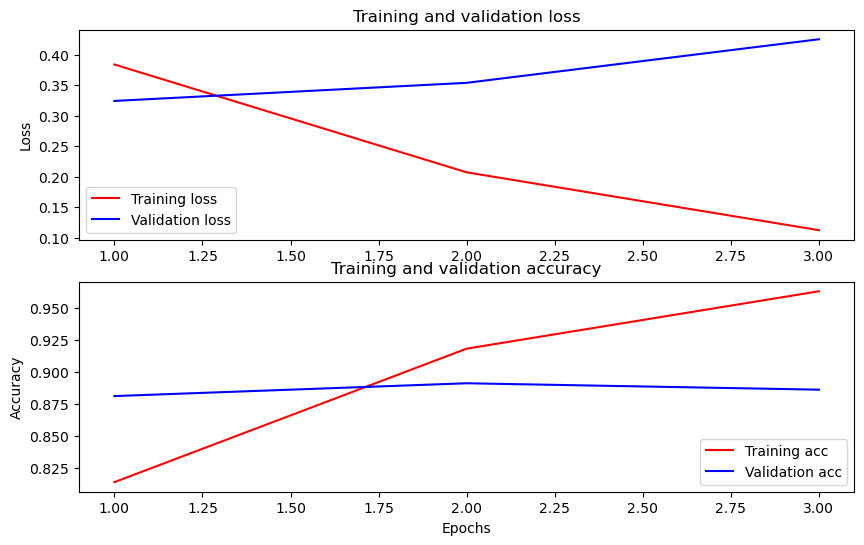

In [20]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Saving fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

clf_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so we can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [28]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is really a very good series!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was so bad.',
    'The movie was pretty cool.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(clf_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is really a very good series! : score: 0.998973
input: The movie was great!           : score: 0.997168
input: The movie was so bad.          : score: 0.002638
input: The movie was pretty cool.     : score: 0.994924
input: The movie was terrible...      : score: 0.000916

Results from the model in memory:
input: this is really a very good series! : score: 0.998973
input: The movie was great!           : score: 0.997168
input: The movie was so bad.          : score: 0.002638
input: The movie was pretty cool.     : score: 0.994924
input: The movie was terrible...      : score: 0.000916



For model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving)

NB: it will call SavedModel through one of its named signatures.

In [29]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is really a very good series! : score: 0.998973
input: The movie was great!           : score: 0.997168
input: The movie was so bad.          : score: 0.002638
input: The movie was pretty cool.     : score: 0.994924
input: The movie was terrible...      : score: 0.000916

